In [1]:
import sympy as sp
from sympy import abc

In [2]:
from scipy.integrate import quad
from scipy.special import dawsn
import numpy as np
from functools import lru_cache
import scipy.optimize as opt
import numdifftools as nd

# Ферромагнетик

## Выражение для $Z^{(3)}$

### Определения

In [3]:
class SigmaSymbol(sp.Symbol):
    def _latex(self, printer, exp=None):
        if exp is None:
            return self.name
        else:
            exp = printer.doprint(exp)
            return f"{self.name}^{exp}"

    def _eval_power(self, expt):
        if expt.is_integer:
            d, m = divmod(expt, 2)
            return self**m


SIGMAS = [-1, 1]

### Аргументы

In [4]:
h1, h2 = sp.symbols("h_1 h_2", positive=True)
p = sp.Symbol("p", positive=True)
l = sp.Symbol("\\lambda", positive=True)
l_ik = sp.Symbol("\\lambda_{ik}", positive=True) 
s1, s2, s3 = SigmaSymbol("\\sigma_1"), SigmaSymbol("\\sigma_2"),  SigmaSymbol("\\sigma_3")

In [5]:
x, t = abc.x, abc.t
arg_exp = h2*x
arg_exp = arg_exp.replace(
    x, sp.solve(sp.sqrt(h1**2+l**2+2*h1*l*x)-t, x)[0]
).expand()
arg_exp += (s1+s2)*t + s1*s2*l_ik
expr_limit = h1+s3*l
arg_F2 = (t+(s1+s2)*l_ik)/sp.sqrt(2*l_ik)

arg_exp = arg_exp.replace(t, t-(s1+s2)*l*h1/h2).expand()
arg_F2 = arg_F2.replace(t, t-(s1+s2)*l*h1/h2).expand()
expr_limit += (s1+s2)*l*h1/h2

arg_exp = arg_exp.replace(t, t*sp.sqrt(2*l*h1/h2)).expand()
arg_F2 = arg_F2.replace(t, t*sp.sqrt(2*l*h1/h2)).expand()
expr_limit /= sp.sqrt(2*l*h1/h2)

display(arg_exp)
display(arg_F2)
display(expr_limit)

-\sigma_1*\sigma_2*\lambda*h_1/h_2 + \sigma_1*\sigma_2*\lambda_{ik} - \lambda*h_1/h_2 - \lambda*h_2/(2*h_1) + t**2 - h_1*h_2/(2*\lambda)

-sqrt(2)*\sigma_1*\lambda*h_1/(2*sqrt(\lambda_{ik})*h_2) + sqrt(2)*\sigma_1*sqrt(\lambda_{ik})/2 - sqrt(2)*\sigma_2*\lambda*h_1/(2*sqrt(\lambda_{ik})*h_2) + sqrt(2)*\sigma_2*sqrt(\lambda_{ik})/2 + sqrt(\lambda)*sqrt(h_1)*t/(sqrt(\lambda_{ik})*sqrt(h_2))

sqrt(2)*sqrt(h_2)*(\sigma_3*\lambda + \lambda*h_1*(\sigma_1 + \sigma_2)/h_2 + h_1)/(2*sqrt(\lambda)*sqrt(h_1))

In [6]:
arg_exp -= t**2
arg_exp += expr_limit**2
arg_exp = arg_exp.expand()
display(arg_exp)

\sigma_1*\sigma_2*\lambda_{ik} + \sigma_1*\sigma_3*\lambda + \sigma_1*h_1 + \sigma_2*\sigma_3*\lambda + \sigma_2*h_1 + \sigma_3*h_2

### Производные $F^{(3)}$

In [7]:
class F2Function(sp.Function):
    def _latex(self, printer, exp=None):
        arg = printer.doprint(self.args[0])
        if exp is None:
            return "F^{(2)}"+f"\\left({arg}\\right)"
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"

    def fdiff(self, argindex=1):
        return 1-2*self.args[0]*F2Function(self.args[0])
    
    def _eval_rewrite(self, rule, args, **hints):
        x, = args
        if rule == sp.erfi:
            return sp.sqrt(sp.pi)/2*sp.exp(-x**2)*sp.erfi(x)

In [8]:
t, x, a, b = abc.t, abc.x, abc.a, abc.b

In [9]:
F2Function(a*t+b).diff(t).expand()

-2*a**2*t*F2Function(a*t + b) - 2*a*b*F2Function(a*t + b) + a

In [10]:
def get_I2_n(x, n):
    """I^{(2)}_n(x)"""
    _expr_n_0 = 1/sp.sqrt(a)*F2Function(sp.sqrt(a)*x)*sp.exp(x**2*(a-1))
    _expr_n_1 = 1/(2*a)*sp.exp(-x**2)*(sp.exp(x**2*a)-1)

    k = n // 2
    if n % 2 == 0:
        return _expr_n_0.diff(a, k).replace(a, 1).expand()
    else:
        return _expr_n_1.diff(a, k).replace(a, 1).expand()

In [11]:
get_I2_n(x, 2)

x/2 - F2Function(x)/2

In [12]:
class F3Function(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3 = list(map(printer.doprint, self.args))
        return "F^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 

In [13]:
def get_I3_n(x, a, b, n):
    """I^{(3)}_n(x, a, b)"""
    if a == 1:
        if b == 0:
            result = x**(n+1)*F2Function(x)
            result -= get_I2_n(x, n+1)
            return result/(n+1)

        # b != 0
        result = -x**n*F2Function(x+b)
        result += get_I2_n(x, n)

        if n == 0:
            result += sp.exp(-x**2)*F2Function(b)
        if n != 0:
            result += n*get_I3_n(x, a, b, n-1)

        return result/(2*b)

    # a != 1, b != 0
    if n == 0:
        return F3Function(x, a, b)

    result = x**(n-1)*F2Function(a*x+b)
    result -= a*get_I2_n(x, n-1)
    result += 2*a*b*get_I3_n(x, a, b, n-1)

    if n == 1:
        result -= sp.exp(-x**2)*F2Function(b)
    if n != 1:
        result -= (n-1)*get_I3_n(x, a, b, n-2)
    
    return result/(2*(1-a**2))

In [14]:
get_I3_n(x, 1, 0, 0).expand()

x*F2Function(x) - 1/2 + exp(-x**2)/2

In [15]:
expr_F3_diff_b = -2*a*get_I3_n(x, a, b, 1)-2*b*get_I3_n(x, a, b, 0)+get_I2_n(x, 0)
expr_F3_diff_b = expr_F3_diff_b.simplify()

expr_F3_diff_b_factor = a**2-1
expr_F3_diff_b = (expr_F3_diff_b*expr_F3_diff_b_factor).expand()
 
sp.print_latex(expr_F3_diff_b)
sp.print_latex(expr_F3_diff_b_factor)
display(expr_F3_diff_b)
display(expr_F3_diff_b_factor)
print("expr_F3_diff_b = ", expr_F3_diff_b)
print("expr_F3_diff_b_factor = ", expr_F3_diff_b_factor)

- a F^{(2)}\left(b\right) e^{- x^{2}} + a F^{(2)}\left(a x + b\right) + 2 b F^{(3)}\left(x \, | \, a, b \right) - F^{(2)}\left(x\right)
a^{2} - 1


-a*F2Function(b)*exp(-x**2) + a*F2Function(a*x + b) + 2*b*F3Function(x, a, b) - F2Function(x)

a**2 - 1

expr_F3_diff_b =  -a*F2Function(b)*exp(-x**2) + a*F2Function(a*x + b) + 2*b*F3Function(x, a, b) - F2Function(x)
expr_F3_diff_b_factor =  a**2 - 1


In [16]:
expr_F3_diff_a = -2*a*get_I3_n(x, a, b, 2)-2*b*get_I3_n(x, a, b, 1)+get_I2_n(x, 1)
expr_F3_diff_a = expr_F3_diff_a.expand().simplify()

expr_F3_diff_a_factor = (a**2-1)**2
expr_F3_diff_a = (expr_F3_diff_a*expr_F3_diff_a_factor).expand()
expr_F3_diff_a = expr_F3_diff_a.expand()

like_terms = [
    F3Function(x, a, b), F2Function(x), F2Function(a*x+b), 
    F2Function(b)*sp.exp(-x**2), sp.exp(-x**2)
]
expr_F3_diff_a = sp.collect(expr_F3_diff_a, like_terms)

sp.print_latex(expr_F3_diff_a)
sp.print_latex(expr_F3_diff_a_factor)
display(expr_F3_diff_a)
display(expr_F3_diff_a_factor)
print("expr_F3_diff_a = ", expr_F3_diff_a)
print("expr_F3_diff_a_factor = ", expr_F3_diff_a_factor)


- \frac{a^{2}}{2} + a b F^{(2)}\left(x\right) + b F^{(2)}\left(b\right) e^{- x^{2}} + \left(\frac{a^{2}}{2} - \frac{1}{2}\right) e^{- x^{2}} + \left(- a^{3} - 2 a b^{2} + a\right) F^{(3)}\left(x \, | \, a, b \right) + \left(a^{3} x - a x - b\right) F^{(2)}\left(a x + b\right) + \frac{1}{2}
\left(a^{2} - 1\right)^{2}


-a**2/2 + a*b*F2Function(x) + b*F2Function(b)*exp(-x**2) + (a**2/2 - 1/2)*exp(-x**2) + (-a**3 - 2*a*b**2 + a)*F3Function(x, a, b) + (a**3*x - a*x - b)*F2Function(a*x + b) + 1/2

(a**2 - 1)**2

expr_F3_diff_a =  -a**2/2 + a*b*F2Function(x) + b*F2Function(b)*exp(-x**2) + (a**2/2 - 1/2)*exp(-x**2) + (-a**3 - 2*a*b**2 + a)*F3Function(x, a, b) + (a**3*x - a*x - b)*F2Function(a*x + b) + 1/2
expr_F3_diff_a_factor =  (a**2 - 1)**2


In [17]:
class F3Function(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3 = list(map(printer.doprint, self.args))
        return "F^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 

    def fdiff(self, argindex=1):
        x, a, b = self.args

        if argindex == 1:
            return F2Function(a*x+b)-2*x*F3Function(*self.args)

        if argindex == 2:
            expr_F3_diff_a_factor =  (a**2 - 1)**2
            expr_F3_diff_a = -a**2/2 + sp.Rational(1, 2)
            expr_F3_diff_a += a*b*F2Function(x) 
            expr_F3_diff_a += b*F2Function(b)*sp.exp(-x**2) 
            expr_F3_diff_a += (a**2/2 - sp.Rational(1, 2))*sp.exp(-x**2) 
            expr_F3_diff_a += (-a**3 - 2*a*b**2 + a)*F3Function(x, a, b) 
            expr_F3_diff_a += (a**3*x - a*x - b)*F2Function(a*x + b)
            return expr_F3_diff_a/expr_F3_diff_a_factor
        
        if argindex == 3:
            expr_F3_diff_b_factor =  a**2 - 1
            expr_F3_diff_b =  -a*F2Function(b)*sp.exp(-x**2) 
            expr_F3_diff_b += a*F2Function(a*x + b) 
            expr_F3_diff_b += 2*b*F3Function(x, a, b) 
            expr_F3_diff_b -= F2Function(x)
            return expr_F3_diff_b/expr_F3_diff_b_factor  

In [18]:
F3Function(x, a, b).diff(b)

(-a*F2Function(b)*exp(-x**2) + a*F2Function(a*x + b) + 2*b*F3Function(x, a, b) - F2Function(x))/(a**2 - 1)

In [19]:
F3Function(x, a, b).diff(a)

(-a**2/2 + a*b*F2Function(x) + b*F2Function(b)*exp(-x**2) + (a**2/2 - 1/2)*exp(-x**2) + (-a**3 - 2*a*b**2 + a)*F3Function(x, a, b) + (a**3*x - a*x - b)*F2Function(a*x + b) + 1/2)/(a**2 - 1)**2

In [20]:
expr_F3_diff_b_degenerate = -2*get_I3_n(x, 1, 0, 1)+get_I2_n(x, 0)
expr_F3_diff_b_degenerate = expr_F3_diff_b_degenerate.simplify()
expr_F3_diff_b_degenerate = sp.collect(expr_F3_diff_b_degenerate, F2Function(x))
 
sp.print_latex(expr_F3_diff_b_degenerate)
display(expr_F3_diff_b_degenerate)
print("expr_F3_diff_b = ", expr_F3_diff_b_degenerate)

\frac{x}{2} + \left(\frac{1}{2} - x^{2}\right) F^{(2)}\left(x\right)


x/2 + (1/2 - x**2)*F2Function(x)

expr_F3_diff_b =  x/2 + (1/2 - x**2)*F2Function(x)


In [21]:
expr_F3_diff_a_degenerate = -2*get_I3_n(x, 1, 0, 2)+get_I2_n(x, 1)
expr_F3_diff_a_degenerate = expr_F3_diff_a_degenerate.simplify()
expr_F3_diff_a_degenerate = sp.collect(expr_F3_diff_a_degenerate, [x**2/3])
 
sp.print_latex(expr_F3_diff_a_degenerate)
display(expr_F3_diff_a_degenerate)
print("expr_F3_diff_a = ", expr_F3_diff_a_degenerate)

\frac{x^{2} \left(- 2 x F^{(2)}\left(x\right) + 1\right)}{3} + \frac{1}{6} - \frac{e^{- x^{2}}}{6}


x**2*(-2*x*F2Function(x) + 1)/3 + 1/6 - exp(-x**2)/6

expr_F3_diff_a =  x**2*(-2*x*F2Function(x) + 1)/3 + 1/6 - exp(-x**2)/6


In [22]:
class F3Function_degenerate(sp.Function):
    def _latex(self, printer, exp=None):
        arg1, arg2, arg3 = list(map(printer.doprint, self.args))
        return "F^{(3)}"+f"\\left({arg1} \, | \, {arg2}, {arg3} \\right)" 

    def fdiff(self, argindex=1):
        x, a, b = self.args

        if argindex == 1:
            return (F2Function(a*x+b)-2*x*F3Function_degenerate(x, a, b)).doit()

        if argindex == 2:
            expr_F3_diff_a =  x**2*(1 - 2*x*F2Function(x))/3 + (1 - sp.exp(-x**2))/6
            return expr_F3_diff_a.doit()
        
        if argindex == 3:
            expr_F3_diff_b =  x/2 + (sp.Rational(1, 2) - x**2)*F2Function(x)
            return expr_F3_diff_b .doit()

    def doit(self):
        x = self.args[0]
        return x*F2Function(x) - (1-sp.exp(-x**2))/2

In [23]:
F3Function_degenerate(x, a, b).diff(x).doit()

-2*x*(x*F2Function(x) - 1/2 + exp(-x**2)/2) + F2Function(a*x + b)

### Производные $\cal F^{(3)}$

In [24]:
arg_x = (h1+s3*l+(s1+s2)*h1/h2*l)/sp.sqrt(2*h1/h2*l)
arg_a = sp.sqrt(h1/h2*l)/sp.sqrt(l_ik)
arg_b = (s1+s2)/sp.sqrt(2*l_ik)*(l_ik-h1/h2*l)
arg_expr = s3*h2+s1*s2*l_ik+(s1+s2)*(h1+s3*l)

In [25]:
expr = arg_x*arg_a+arg_b
expr.factor()

sqrt(2)*(\sigma_1*\lambda_{ik} + \sigma_2*\lambda_{ik} + \sigma_3*\lambda + h_1)/(2*sqrt(\lambda_{ik}))

In [26]:
expr = arg_expr-arg_x**2
expr = expr.expand()
expr

-\sigma_1*\sigma_2*\lambda*h_1/h_2 + \sigma_1*\sigma_2*\lambda_{ik} - \lambda*h_1/h_2 - \lambda*h_2/(2*h_1) - h_1*h_2/(2*\lambda)

In [27]:
_sub_expr_E = sp.exp(arg_expr).expand()
_sub_expr_F = F2Function(arg_x).expand()
_sub_expr_F_tilde = F2Function(arg_x*arg_a+arg_b).expand()
_sub_expr_cF3 = F3Function(arg_x, arg_a, arg_b).expand()
_sub_expr_cF3_degenerate = F3Function_degenerate(arg_x, arg_a, arg_b).expand()

_dummy_subs = {
    _sub_expr_E*_sub_expr_cF3: sp.Dummy(),
    _sub_expr_E*_sub_expr_F: sp.Dummy(),
    _sub_expr_E*_sub_expr_F_tilde: sp.Dummy(),
    _sub_expr_E: sp.Dummy()
}


def sigmas_sum(expr):
    expr = expr.expand().subs(_dummy_subs)

    terms = sp.collect(expr, _dummy_subs.values(), evaluate=False)
    for dummy in _dummy_subs.values():
        if dummy in terms:
            terms[dummy] = sp.Poly(terms[dummy], [s1, s2, s3]).as_dict()
    for key, dummy in _dummy_subs.items():
        if dummy in terms:
            terms[key] = terms.pop(dummy)

    return terms

In [28]:
class Z3SigmasFunctionBase(sp.Function):
    def __init__(self, name, *args, **kwargs):
        self.name = name

    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args[:4]))
        args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"

        indexes = ""
        for i, item in enumerate(self.args[4:]):
            if item:
                indexes += str(i+1)
        name = f"{self.name}"+"_{" + indexes + "}"

        if exp is None:
            return name+args
        else:
            exp = printer.doprint(exp)
            return f"{name}^{exp}"+args

    def get_sigmas_factor(self):
        factor = 1
        if self.args[4]:
            factor *= s1
        if self.args[5]:
            factor *= s2
        if self.args[6]:
            factor *= s3
        return factor

In [29]:
class EFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__("{\\cal E}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E).diff([h1, h2, l, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h1, h2, l, l_ik], self.args[:4]))

        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.subs(subs)*EFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return EFunction(*args[:4], 1, 0, args[-1])

In [30]:
EFunction(h1, h2, l, l_ik, 1, 1, 1).diff(h1)

2*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1)

In [31]:
class FFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__("{\\cal F}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E*_sub_expr_F).diff([h1, h2, l, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h1, h2, l, l_ik], self.args[:4]))

        result = 0
        if _sub_expr_E in terms:
            for key, item in terms[_sub_expr_E].items():
                result += item.subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F].items():
            result += item.subs(subs)*FFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return FFunction(*args[:4], 1, 0, args[-1])

In [32]:
FFunction(h1, h2, l, l_ik, 1, 1, 1).diff(l_ik)

FFunction(h_1, h_2, \lambda, \lambda_{ik}, 0, 0, 1)

In [33]:
class FTildeFunction(Z3SigmasFunctionBase):
    def __init__(self, *args, **kwargs):
        super().__init__( "\\tilde{\\cal F}", *args, **kwargs)

    def fdiff(self, argindex=1):
        factor = self.get_sigmas_factor()
        expr = (factor*_sub_expr_E*_sub_expr_F_tilde).diff([h1, h2, l, l_ik][argindex-1])
        terms = sigmas_sum(expr)

        subs = dict(zip([h1, h2, l, l_ik], self.args[:4]))

        result = 0
        if _sub_expr_E in terms:
            for key, item in terms[_sub_expr_E].items():
                result += item.subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
            result += item.subs(subs)*FTildeFunction(*self.args[:4], *key)

        return result

    @classmethod
    def eval(cls, *args):
        if (not args[4]) and args[5]:
            return FTildeFunction(*args[:4], 1, 0, args[-1])

In [34]:
FTildeFunction(h1, h2, l, l_ik, 1, 1, 1).diff(h1)

-\lambda*FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0)/\lambda_{ik} - h_1*FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/\lambda_{ik} + sqrt(2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*sqrt(\lambda_{ik}))

In [35]:
class cF3Function(sp.Function):
    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args[:4]))
        args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"
        if exp is None:
            return "{\\cal F}^{(3)}"+args
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"
    
    def fdiff(self, argindex=1):
        expr = (s1*s2*s3*_sub_expr_E*_sub_expr_cF3).diff([h1, h2, l, l_ik][argindex-1])
        terms = sigmas_sum(expr)
        
        subs = dict(zip([h1, h2, l, l_ik], self.args[:4]))

        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.factor().subs(subs)*EFunction(*self.args[:4], *key)

        for key, item in terms[_sub_expr_E*_sub_expr_F].items():
            result += item.factor().subs(subs)*FFunction(*self.args[:4], *key)
        
        for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
            result += item.factor().subs(subs)*FTildeFunction(*self.args[:4], *key)
        
        _term = terms[_sub_expr_E*_sub_expr_cF3][(1, 1, 1)].factor().subs(subs)
        result += _term*cF3Function(*self.args)

        return result

In [36]:
sp.Add(*map(lambda x: x*4*l*h1**2*sp.sqrt(h2)*(l*h1-l_ik*h2), cF3Function(h1, h2, l, l_ik).diff(h1).args))

-\lambda**(3/2)*sqrt(\lambda_{ik})*h_1**(3/2)*h_2*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1) + sqrt(2)*\lambda**(3/2)*\lambda_{ik}*sqrt(h_1)*h_2**2*FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0) + sqrt(2)*sqrt(\lambda)*h_1**(3/2)*h_2*(2*\lambda*h_1 - \lambda_{ik}*h_2)*FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1) + 2*sqrt(2)*\lambda**2*sqrt(\lambda_{ik})*h_1**2*sqrt(h_2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1) + 2*sqrt(h_2)*(\lambda**3*h_1*h_2 - \lambda**2*\lambda_{ik}*h_2**2 - \lambda**2*h_1**2 - \lambda*h_1**3*h_2 + \lambda_{ik}*h_1**2*h_2**2)*cF3Function(h_1, h_2, \lambda, \lambda_{ik})

In [37]:
class cF3Function_degenerate(sp.Function):
    def _latex(self, printer, exp=None):
        args = list(map(printer.doprint, self.args[:4]))
        args = f"\\left({args[0]}, {args[1]}, {args[2]}, {args[3]}\\right)"
        if exp is None:
            return "{\\cal F}^{(3)}"+args
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"
    
    def fdiff(self, argindex=1):
        expr = s1*s2*s3*_sub_expr_E*_sub_expr_cF3_degenerate
        expr = expr.diff([h1, h2, l, l_ik][argindex-1]).doit()
        terms = sigmas_sum(expr)
        
        subs = dict(zip([h1, h2, l, l_ik], self.args[:4]))

        result = 0
        for key, item in terms[_sub_expr_E].items():
            result += item.factor().subs(subs)*EFunction(*self.args[:4], *key)

        if _sub_expr_E*_sub_expr_F in terms:
            for key, item in terms[_sub_expr_E*_sub_expr_F].items():
                result += item.factor().subs(subs)*FFunction(*self.args[:4], *key)
        
        if _sub_expr_E*_sub_expr_F_tilde in terms:
            for key, item in terms[_sub_expr_E*_sub_expr_F_tilde].items():
                result += item.factor().subs(subs)*FTildeFunction(*self.args[:4], *key)
        
        return result

In [38]:
# cF3Function_degenerate(h1, h2, l, l_ik).diff(h1)

### Расчет $F^{(2)}$ и $F^{(3)}$

#### Символьные вычисления

##### Определения

In [39]:
FFunction(h1, h2, l, l_ik, 1, 1, 1).diff(h1)

sqrt(2)*sqrt(\lambda)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1)/(2*sqrt(h_1)*sqrt(h_2)) - sqrt(2)*sqrt(\lambda)*sqrt(h_2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0)/(4*h_1**(3/2)) - \lambda*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 0, 0, 1)/h_2 + (-2*\lambda**2*h_1**2 + \lambda**2*h_2**2 - h_1**2*h_2**2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*\lambda*h_1**2*h_2) + sqrt(2)*sqrt(h_2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(4*sqrt(\lambda)*sqrt(h_1))

In [40]:
class erfcx(sp.Function):
    def _latex(self, printer, exp=None):
        arg = printer.doprint(self.args[0])
        if exp is None:
            return "\operatorname{erfcx}"+f"\\left({arg}\\right)"
        else:
            exp = printer.doprint(exp)
            return f"\\left({self._latex(printer)}\\right)^{exp}"

In [41]:
def erfi_to_dawsn(expr):
    def __helper(z):
        return F2Function(z)*2/sp.sqrt(sp.pi)*sp.exp(z**2)
    return expr.replace(sp.erfi, __helper)


def erfc_to_erfcx(expr):
    def __helper(z):
        return erfcx(z)*sp.exp(-z**2)
    return expr.replace(sp.erfc, __helper)

In [42]:
t, x, a, b = abc.t, abc.x, abc.a, abc.b
n, h = abc.n, abc.h
n0 = sp.Symbol("n_0")

##### $c > 0$

In [43]:
c = sp.Symbol("c", positive=True)
expr = t**2-(a*t+b-n*h)**2
expr = expr.expand()
expr = expr.replace(a**2, 1-c).expand()
expr = sp.integrate(sp.exp(expr), [t, 0, x])*sp.exp(-x**2)/(n*sp.sqrt(sp.pi))
expr = expr.expand()
expr = erfi_to_dawsn(expr)
expr = sp.Add(*map(lambda x: x.simplify(), expr.args))
expr

F2Function((-a*b + a*h*n + c*x)/sqrt(c))*exp(-2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2)/(sqrt(pi)*sqrt(c)*n) + F2Function(a*(b - h*n)/sqrt(c))*exp(-b**2 + 2*b*h*n - h**2*n**2 - x**2)/(sqrt(pi)*sqrt(c)*n)

In [44]:
print(sp.solve(expr.args[0].args[-1].diff(n), n)[0])

(a*x + b)/h


In [45]:
print(sp.solve(expr.args[1].args[-1].diff(n), n)[0])

b/h


In [46]:
expr = -2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2
expr = expr.replace(n, n0+n).expand()
expr = expr.collect(n)
sp.print_latex(expr)
expr

- 2 a b x + 2 a h n_{0} x - b^{2} + 2 b h n_{0} + c x^{2} - h^{2} n^{2} - h^{2} n_{0}^{2} + n \left(2 a h x + 2 b h - 2 h^{2} n_{0}\right) - x^{2}


-2*a*b*x + 2*a*h*n_0*x - b**2 + 2*b*h*n_0 + c*x**2 - h**2*n**2 - h**2*n_0**2 + n*(2*a*h*x + 2*b*h - 2*h**2*n_0) - x**2

In [47]:
expr = -b**2 + 2*b*h*n - h**2*n**2 - x**2
expr = expr.replace(n, n0+n).expand()
expr = expr.collect(n)
sp.print_latex(expr)
expr

- b^{2} + 2 b h n_{0} - h^{2} n^{2} - h^{2} n_{0}^{2} + n \left(2 b h - 2 h^{2} n_{0}\right) - x^{2}


-b**2 + 2*b*h*n_0 - h**2*n**2 - h**2*n_0**2 + n*(2*b*h - 2*h**2*n_0) - x**2

##### $c < 0$

In [48]:
c = sp.Symbol("c", negative=True)
expr = t**2-(a*t+b-n*h)**2
expr = expr.expand()
expr = expr.replace(a**2, 1-c).expand()
expr = sp.integrate(sp.exp(expr), [t, 0, x])*sp.exp(-x**2)/(n*sp.sqrt(sp.pi))
expr = expr.simplify()
sp.print_latex(expr)
display(expr)

expr = expr.rewrite(sp.erfc)
expr = expr.expand().factor().simplify()
display(expr)
expr = erfc_to_erfcx(expr).expand()
expr = sp.Add(*map(lambda x: x.simplify(), expr.args))
sp.print_latex(expr)
display(expr)

\frac{\left(\operatorname{erf}{\left(\frac{a b - a h n - c x}{\sqrt{- c}} \right)} - \operatorname{erf}{\left(\frac{a \left(b - h n\right)}{\sqrt{- c}} \right)}\right) e^{\frac{- a^{2} b^{2} - a^{2} h^{2} n^{2} - b^{2} c + 2 b h n \left(a^{2} + c\right) - c h^{2} n^{2} - c x^{2}}{c}}}{2 n \sqrt{- c}}


(erf((a*b - a*h*n - c*x)/sqrt(-c)) - erf(a*(b - h*n)/sqrt(-c)))*exp((-a**2*b**2 - a**2*h**2*n**2 - b**2*c + 2*b*h*n*(a**2 + c) - c*h**2*n**2 - c*x**2)/c)/(2*n*sqrt(-c))

(erfc((-a*b + a*h*n + c*x)/sqrt(-c)) + erfc(a*(b - h*n)/sqrt(-c)) - 2)*exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)/(2*n*sqrt(-c))

\frac{\operatorname{erfcx}\left(\frac{- a b + a h n + c x}{\sqrt{- c}}\right) e^{- 2 a b x + 2 a h n x - b^{2} + 2 b h n + c x^{2} - h^{2} n^{2} - x^{2}}}{2 n \sqrt{- c}} + \frac{\operatorname{erfcx}\left(\frac{a \left(b - h n\right)}{\sqrt{- c}}\right) e^{- b^{2} + 2 b h n - h^{2} n^{2} - x^{2}}}{2 n \sqrt{- c}} - \frac{e^{- \frac{a^{2} b^{2}}{c} + \frac{2 a^{2} b h n}{c} - \frac{a^{2} h^{2} n^{2}}{c} - b^{2} + 2 b h n - h^{2} n^{2} - x^{2}}}{n \sqrt{- c}}


erfcx((-a*b + a*h*n + c*x)/sqrt(-c))*exp(-2*a*b*x + 2*a*h*n*x - b**2 + 2*b*h*n + c*x**2 - h**2*n**2 - x**2)/(2*n*sqrt(-c)) + erfcx(a*(b - h*n)/sqrt(-c))*exp(-b**2 + 2*b*h*n - h**2*n**2 - x**2)/(2*n*sqrt(-c)) - exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)/(n*sqrt(-c))

In [49]:
print(expr.args[0].args[-1].args[0].simplify())

(-a**2*b**2 + 2*a**2*b*h*n - a**2*h**2*n**2 + c*(-b**2 + 2*b*h*n - h**2*n**2 - x**2))/c


In [50]:
expr = sp.exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)
expr = expr.diff(n)
display(expr)
print(sp.solve(expr, n))

print(sp.expand(expr.args[0]/(2*h)))

(2*a**2*b*h/c - 2*a**2*h**2*n/c + 2*b*h - 2*h**2*n)*exp(-a**2*b**2/c + 2*a**2*b*h*n/c - a**2*h**2*n**2/c - b**2 + 2*b*h*n - h**2*n**2 - x**2)

[b/h]
a**2*b/c - a**2*h*n/c + b - h*n


#### Численный расчет

##### $F^{(2)}$ 

In [51]:
def f_F2Function(x):
    return dawsn(x)


def f_F2Function_int(x):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2), 0, x)[0]


def f_F2Function_series(x, NMAX, H):
    xx = np.abs(x)
    n0 = 2*np.int_(0.5*xx/H+0.5)
    xp = xx-n0*H

    e1 = np.exp(2.0*xp*H)
    e2 = e1*e1
    d1 = n0+1
    d2 = d1-2.0

    result = 0.0
    for i in range(NMAX):
        result += np.exp(-((2.0*i+1.0)*H)**2)*(e1/d1+1.0/(d2*e1))
        d1 = d1 + 2.0
        d2 = d2 - 2.0
        e1 = e1*e2

    return 0.5641895835*np.exp(-xp*xp)*np.sign(x)*result

In [52]:
def calc_err(NMAX, H):
    max_err = 0
    for x in np.linspace(-10, 10, 100):
        err = np.abs(f_F2Function_series(x, NMAX, H)-f_F2Function_int(x))
        if max_err < err:
            max_err = err
    return max_err

In [53]:
# import matplotlib.pyplot as plt

# N_arr = np.arange(1, 16)
# err_arr = []

# H = 0.2
# for N in N_arr:
#     err_arr.append(calc_err(N, H))

# plt.yscale("log")
# plt.plot(N_arr, err_arr)

##### $F^{(3)}$ 

In [54]:
from scipy.special import erfc, erfcx

In [55]:
def f_F3Function_int_dawsn(x, a, b):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2)*f_F2Function(a*t+b), 0, x)[0]

def f_F3Function_int_int(x, a, b):
    return np.exp(-x**2)*quad(lambda t: np.exp(t**2)*f_F2Function_int(a*t+b), 0, x)[0]

In [56]:
def __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h):
    n1 = n0+1
    n2 = n0-1

    arg1 = arg_func(n1)
    arg2 = arg_func(n2)

    e1 = np.exp(arg0_exp + .5*delta_arg_exp)
    e2 = np.exp(arg0_exp - .5*delta_arg_exp)
    delta_exp = np.exp(delta_arg_exp)

    S = 0
    for i in range(NMAX):
        n = 2*i+1
        delta = func(arg1)*e1*np.exp(-h**2*n**2)/n1
        S += delta

        n = -2*i-1
        delta = func(arg2)*e2*np.exp(-h**2*n**2)/n2
        S += delta

        n1 += 2
        n2 -= 2
        arg1 = arg_func(n1)
        arg2 = arg_func(n2)
        e1 *= delta_exp
        e2 /= delta_exp

    return S


def _term1_f_F3Function_series(func, x, a, b, c, _sqrt_c, NMAX, h):
    xx = (a*x + b)/h
    n0 = 2*np.int_(0.5*xx+np.sign(xx)*0.5)
    arg_func = lambda n: (-a*b + c*x + n*a*h)*_sqrt_c
    arg0_exp = 2*b*h*n0-h**2*n0**2+2*a*h*n0*x-2*a*b*x+c*x**2-b**2-x**2
    delta_arg_exp = 4*a*h*x + 4*b*h - 4*h**2*n0
    return __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h)


def _term2_f_F3Function_series(func, x, a, b, _sqrt_c, NMAX, h):
    xx = b/h
    n0 = 2*np.int_(0.5*xx+np.sign(xx)*0.5)
    arg_func = lambda n: -a*(b - h*n)*_sqrt_c
    arg0_exp = 2*b*h*n0-h**2*n0**2-b**2-x**2
    delta_arg_exp = 4*b*h - 4*h**2*n0
    return __sum_f_F3Function_series(n0, arg_func, func, arg0_exp, delta_arg_exp, NMAX, h)

In [57]:
def antisymmetric_erfcx(x):
    if x < 0:
        return -erfcx(-x)
    return erfcx(x)


def f_F3Function_series(x, a, b, NMAX=None, h=None):
    if np.isnan(x) or np.isnan(a) or np.isnan(b):
        return np.nan
    if np.isinf(x) or np.isinf(a) or np.isinf(b):
        return np.nan

    c = 1-a**2

    if c == 1:
        return f_F2Function(x) * f_F2Function(b)

    if c > 0:
        if NMAX is None:
            NMAX = 6
        if h is None: 
            h = 0.4

        sqrt_c = np.sqrt(c)
        _sqrt_c = 1/sqrt_c

        S = _term1_f_F3Function_series(f_F2Function, x, a, b, c, _sqrt_c, NMAX, h)
        S -= _term2_f_F3Function_series(f_F2Function, x, a, b, _sqrt_c, NMAX, h)

        return S/np.sqrt(np.pi)*_sqrt_c
    
    if c < 0:
        if NMAX is None:
            NMAX = 6
        if h is None: 
            h = 0.4

        sqrt_c = np.sqrt(-c)
        _sqrt_c = 1/sqrt_c
        
        S = _term1_f_F3Function_series(antisymmetric_erfcx, x, a, b, c, _sqrt_c, NMAX, h)
        S -= _term2_f_F3Function_series(antisymmetric_erfcx, x, a, b, _sqrt_c, NMAX, h)

        factor = -2*np.sign(a)
        left, right = (a*b - c*x)/(a*h), b/h
        if left != right:
            if right < left:
                factor *= -1
                left, right = right, left
      
            n_prob = (left+right)/2
            start, end = left, right
            if a**2*b/c - a**2*h*n_prob/c + b - h*n_prob > 0:
                start, end = end, start

            step = 2*np.sign(end-start)

            n = np.floor(start)
            n = n - 1 + n % 2
            distance = np.abs(end-start)
            if np.abs(n-end) > distance:
                n += step
                
            arg_exp = lambda n: (-a**2*b**2 + 2*a**2*b*h*n - a**2*h**2*n**2)/c - b**2 + 2*b*h*n - h**2*n**2 - x**2
            while True:
                if max(np.abs(n-start), np.abs(n-end)) > distance:
                    break
                if n == left:
                    if a < 0:
                        S -= factor*np.exp(arg_exp(n))/n
                if n == right:
                    if a < 0:
                        S += factor*np.exp(arg_exp(n))/n
                    n += step
                    continue
 
                val_exp = np.exp(arg_exp(n))
                S += factor*val_exp/n
                n += step

                if np.abs(val_exp) - 1e-7*np.abs(S) < 0:
                    break

        return S*.5*_sqrt_c

    # c == 0
    if b == 0:
        return x*f_F2Function(x) - .5*(1-np.exp(-x**2))

    # b != 0
    result = f_F2Function(b)*np.exp(-x**2) 
    result += f_F2Function(x)
    result -= f_F2Function(b+x)
    return result*.5/b

In [58]:
f_F3Function_series(2*2*0.4, -2, 10, 6, 0.4)

np.float64(0.026506412441317653)

In [59]:
f_F3Function_int_dawsn(2*2*0.4, -2, 10)

np.float64(0.0265064114152765)

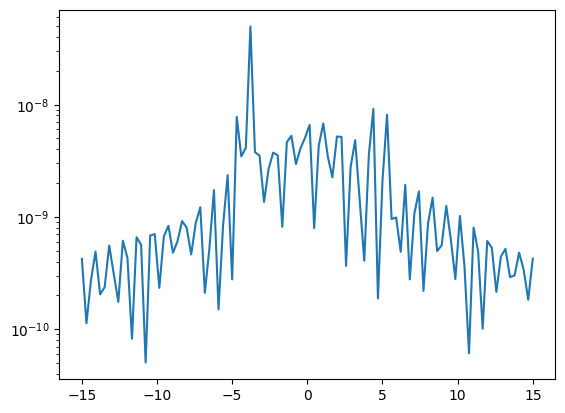

In [60]:
import matplotlib.pyplot as plt

x = np.linspace(-15, 15, 100)
y1 = []
y2 = []
N = []

a, b = 0.9, -1
c = 1 - a**2
for val_x in x:
    y1.append(f_F3Function_int_dawsn(val_x, a, b))
    y2.append(f_F3Function_series(val_x, a, b, 5, 0.4))

y1, y2 = np.asarray(y1), np.asarray(y2)

# plt.plot(x, y1)
# plt.plot(x, y2)
plt.plot(x, np.abs(y1-y2))
plt.yscale("log")

# print(x[np.argmax(np.abs(y1-y2))])

In [61]:
def calc_error(a, NMAX, h):
    max_error = 0
    for x in np.linspace(-15, 15, 100):
        for b in np.linspace(-10, 10, 10):
            error = f_F3Function_int_dawsn(x, a, b)-f_F3Function_series(x, a, b, NMAX, h)
            if np.abs(error) > max_error:
                max_error = np.abs(error)
    return max_error
    

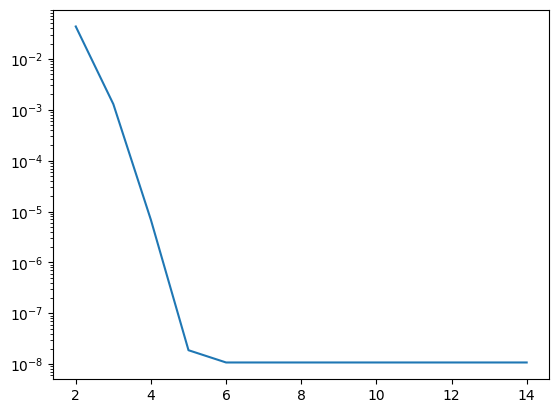

In [62]:
import datlib 

N = np.arange(2, 15)
error = []
a = .9
h = .4

for n in N:
    error.append(calc_error(a, n, h))

plt.yscale("log")
plt.plot(N, error)

In [63]:
# import time

# start = time.time()
# for x in np.linspace(-10, 10, 5):
#     for a in np.linspace(-10, 10, 5):
#         b = 1
#         f_F3Function_int_int(x, a, b)
# end = time.time()
# print(end - start)

In [64]:
import time

start = time.time()
for x in np.linspace(-10, 10, 100):
    for a in np.linspace(-10, 10, 10):
        for b in np.linspace(-10, 10, 10):
            f_F3Function_int_dawsn(x, a, b)
end = time.time()
print(end - start)

2.53671932220459


In [65]:
import time

start = time.time()
for x in np.linspace(-10, 10, 100):
    for a in np.linspace(-10, 10, 10):
        for b in np.linspace(-10, 10, 10):
            f_F3Function_series(x, a, b, 6, 0.4)
end = time.time()
print(end - start)

2.3970508575439453


### Численный расчет

#### Определения

In [66]:
import Z2 as Z2_module

In [67]:
f_F3Function = f_F3Function_series

In [68]:
@lru_cache(maxsize=1)
def _Z3_E_terms(h1, h2, l, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = s3*h2+s1*s2*l_ik+(s1+s2)*(h1+s3*l)
                result[i1, i2, i3] = np.exp(arg)
    return result

@lru_cache(maxsize=1)
def _Z3_F3_terms(h1, h2, l, l_ik):
    _arg1 = lambda s1, s2, s3: (h1+s3*l+(s1+s2)*h1/h2*l)/np.sqrt(2*h1/h2*l)
    _arg2 = np.sqrt(h1/h2*l/l_ik)
    _arg3 = lambda s1, s2: (s1+s2)/np.sqrt(2*l_ik)*(l_ik-h1/h2*l)
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                args = _arg1(s1, s2, s3), _arg2, _arg3(s1, s2)
                result[i1, i2, i3] = f_F3Function(*args)
    return result

@lru_cache(maxsize=1)
def _Z3_F_tilde_terms(h1, h2, l, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = (h1+s3*l+(s1+s2)*l_ik)/np.sqrt(2*l_ik)
                result[i1, i2, i3] = f_F2Function(arg)
    return result

@lru_cache(maxsize=1)
def _Z3_F_terms(h1, h2, l, l_ik):
    result = np.zeros((2, 2, 2))
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                arg = (h1+s3*l+(s1+s2)*h1/h2*l)/np.sqrt(2*h1/h2*l)
                result[i1, i2, i3] = f_F2Function(arg)
    return result

In [69]:
def _Z3_sum_terms(terms, sigmas_func):
    result = 0
    for i1, s1 in enumerate(SIGMAS):
        for i2, s2 in enumerate(SIGMAS):
            for i3, s3 in enumerate(SIGMAS):
                result += sigmas_func(s1, s2, s3)*terms[i1, i2, i3]

    return result

In [70]:
def f_cF3Function(h1, h2, l, l_ik):
    _E_terms = _Z3_E_terms(h1, h2, l, l_ik)
    _F3_terms = _Z3_F3_terms(h1, h2, l, l_ik)
    
    _terms = _E_terms*_F3_terms
    _sigmas_func_123 = lambda s1, s2, s3: s1*s2*s3
   
    return _Z3_sum_terms(_terms, _sigmas_func_123)

In [71]:
def f_Z1(p):
    return 4*np.pi/p*np.sinh(p)

def raw_Z2(h, l):
    def _sqrt(x): return np.sqrt(h**2+l**2+2*h*l*x)
    def func(x): return np.exp(h*x)*f_Z1(_sqrt(x))
    return 2*np.pi*quad(func, -1, 1)[0]

In [72]:
def raw_Z3(h1, h2, l, l_ik):
    _sqrt = lambda x: np.sqrt(h1**2+l**2+2*h1*l*x)
    func = lambda x: np.exp(h2*x)*np.exp(2*_sqrt(x)+l_ik)*Z2_module.calc_Z2_norm(_sqrt(x), l_ik)
    return 2*np.pi*quad(func, -1, 1)[0]


def raw_raw_Z3(h1, h2, l, l_ik):
    _sqrt = lambda x: np.sqrt(h1**2+l**2+2*h1*l*x)
    func = lambda x: np.exp(h2*x)*raw_Z2(_sqrt(x), l_ik)
    return 2*np.pi*quad(func, -1, 1)[0]


def Z3(h1, h2, l, l_ik):
    return 2*(2*np.pi)**3/np.sqrt(h1*h2*l*l_ik)*f_cF3Function(h1, h2, l, l_ik)

In [73]:
v_raw_Z3 = lambda x: raw_Z3(*x)
v_cF3 = lambda x: f_cF3Function(*x)
v_F3 = lambda x: f_F3Function(*x)

In [74]:
def f_EFunction(h1, h2, l, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    return _Z3_sum_terms(_Z3_E_terms(h1, h2, l, l_ik), _sigmas_func)


def f_FTildeFunction(h1, h2, l, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    terms = _Z3_E_terms(h1, h2, l, l_ik)*_Z3_F_tilde_terms(h1, h2, l, l_ik)
    return _Z3_sum_terms(terms, _sigmas_func)


def f_FFunction(h1, h2, l, l_ik, arg_s1, arg_s2, arg_s3):
    def _sigmas_func(s1, s2, s3):
        result = 1
        if arg_s1:
            result *= s1
        if arg_s2:
            result *= s2
        if arg_s3:
            result *= s3
        return result
    terms = _Z3_E_terms(h1, h2, l, l_ik)*_Z3_F_terms(h1, h2, l, l_ik)
    return _Z3_sum_terms(terms, _sigmas_func)


module_dictionary = {"cF3Function": f_cF3Function, "cF3Function_degenerate": f_cF3Function,
                     "EFunction": f_EFunction, 
                     "FTildeFunction": f_FTildeFunction, "FFunction": f_FFunction,
                     "F2Function": f_F2Function, "F3Function": f_F3Function}

module = [module_dictionary, "scipy"]

#### Проверка

In [75]:
args = 1.1, 1.4, 0.9, 1.2

print(raw_Z3(*args))
print(raw_raw_Z3(*args))
print(Z3(*args))

10617.721695485005
10617.721695485003
10617.721784912486


In [76]:
def get_diffs(expr, args):
    diffs = []
    for arg in args:
        diffs.append(sp.lambdify(args, expr.diff(arg), module))
    return diffs

In [77]:
def calc_numerical_diffs(func, args):
    diffs = np.zeros_like(args)
    for i, arg in enumerate(args):
        direction = [0] * len(args)
        direction[i] = 1
        diffs[i] = nd.directionaldiff(func, args, direction, n=1)
    return diffs


def calc_exprs(exprs, args):
    return list(map(lambda expr: expr(*args), exprs))


def compare_exprs(exprs_1, exprs_2):
    for i, expr in enumerate(exprs_1):
        print(expr)
        print(exprs_2[i])
        print()

In [78]:
x, a, b = abc.x, abc.a, abc.b

f_F3_diffs = get_diffs(F3Function(x, a, b), [x, a, b])
f_F3_degenerate_diffs = get_diffs(F3Function_degenerate(x, a, b), [x, a, b])

args = 1.4, -6, 1
compare_exprs(
    calc_numerical_diffs(v_F3, args),
    calc_exprs(f_F3_diffs, args)
)

args = 1.4, 1, 0
compare_exprs(
    calc_numerical_diffs(v_F3, args),
    calc_exprs(f_F3_degenerate_diffs, args)
)

0.0789388044024849
0.0789387929977766

-0.0075467372132369745
-0.007546734847506438

0.008638957666855868
0.008638960478949579

-0.1302029228678329
-0.13020292286800322

-0.03858026434738476
-0.03858031000271166

0.033499433211962616
0.03349943321073001



In [79]:
args_coeffs = h1, h2, l, l_ik

In [80]:
f_E_123 = sp.lambdify(args_coeffs, EFunction(*args_coeffs, 1, 1, 1), module)
f_E_123_diffs = get_diffs(EFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_E_123 = lambda x: f_E_123(*x)

args = 1.1, 1.6, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_f_E_123, args),
    calc_exprs(f_E_123_diffs, args)
)

1793.9908528051935
1793.9908528052451

896.4925453059092
896.4925453059141

1796.193536948808
1796.1935369487762

899.5611861682389
899.5611861682446



In [81]:
f_F_123 = sp.lambdify(args_coeffs, FFunction(*args_coeffs, 1, 1, 1), module)
f_F_123_diffs = get_diffs(FFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_F_123 = lambda x: f_F_123(*x)

args = 1.0, 1.6, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_f_F_123, args),
    calc_exprs(f_F_123_diffs, args)
)

242.96196215703418
242.9619621570704

125.49170030046874
125.49170030046551

247.56814708557008
247.56814708556857

140.24587304244235
140.2458730424406



In [82]:
f_F_tilde_123 = sp.lambdify(args_coeffs, FTildeFunction(*args_coeffs, 1, 1, 1), module)
f_F_tilde_123_diffs = get_diffs(FTildeFunction(*args_coeffs, 1, 1, 1), args_coeffs)
v_f_F_tilde_123 = lambda x: f_F_tilde_123(*x)

args = 1.1, 1.6, 0.9, 1.3
compare_exprs(
    calc_numerical_diffs(v_f_F_tilde_123, args),
    calc_exprs(f_F_tilde_123_diffs, args)
)

326.37914592414165
326.37914592413733

186.48747756171457
186.4874775617166

328.17606098362404
328.1760609836284

176.9750210485126
176.97502104854397



In [83]:
# f_cF3_diffs = get_diffs(cF3Function(*args_coeffs), args_coeffs)
# f_cF3_degenerate_diffs = get_diffs(cF3Function_degenerate(*args_coeffs), args_coeffs)

# args = 1.1, 1.6, 0.9, 1.2
# compare_exprs(
#     calc_numerical_diffs(v_cF3, args),
#     calc_exprs(f_cF3_diffs, args)
# )

# args = 1, 1, 1., 1
# compare_exprs(
#     calc_numerical_diffs(v_cF3, args),
#     calc_exprs(f_cF3_degenerate_diffs, args)
# )

#### Производительность

In [84]:
import time

In [85]:
args = 40, 50, 60, 70
N = 1000

start = time.time()
for _ in range(N):
    Z3(*args)  # без lru_cache!!!

end = time.time()

print(f"{(end - start)/N:.6e}")

1.778531e-05


In [86]:
args = 60, 50, 60, 70
N = 100

start = time.time()
for _ in range(N):
    raw_Z3(*args)

end = time.time()

print(f"{(end - start)/N:.6e}")

1.031677e-02


In [87]:
args = 60, 50, 60, 70
N = 10

start = time.time()
for _ in range(N):
    raw_raw_Z3(*args)

end = time.time()

print(f"{(end - start)/N:.6e}")

1.589931e-01


## Моменты $\cal Z^{(3)}$

### Символьные вычисления

#### Система на первые моменты

In [88]:
m_1 = sp.Symbol("\\left<{m_1}\\right>")
m_2 = sp.Symbol("\\left<{m_2}\\right>")
eta = sp.Symbol("\\left<\\eta\\right>")
eta_ik = sp.Symbol("\\left<\\eta_{ik}\\right>")

In [89]:
Z3_expr = cF3Function(h1, h2, l, l_ik)/sp.sqrt(h1*h2*l*l_ik)

expr_m_1 = sp.log(Z3_expr).diff(h1)/2
expr_m_1 = sp.Add(*map(sp.factor, expr_m_1.expand().args))

expr_m_2 = sp.log(Z3_expr).diff(h2)
expr_m_2 = sp.Add(*map(sp.factor, expr_m_2.expand().args))

expr_eta = sp.log(Z3_expr).diff(l)/2
expr_eta = sp.Add(*map(sp.factor, expr_eta.expand().args))

expr_eta_ik = sp.log(Z3_expr).diff(l_ik)
expr_eta_ik = sp.Add(*map(sp.factor, expr_eta_ik.expand().args))

In [90]:
n, d = sp.fraction(expr_m_1.factor())
_expr_m_1 = n-d*m_1

n, d = sp.fraction(expr_m_2.factor())
_expr_m_2 = n-d*m_2

n, d = sp.fraction(expr_eta.factor())
_expr_eta = n-d*eta

n, d = sp.fraction(expr_eta_ik.factor())
_expr_eta_ik = n-d*eta_ik

In [91]:
moments_like_terms = [
    cF3Function(h1, h2, l, l_ik),
    FTildeFunction(h1, h2, l, l_ik, 1, 1, 1),
    FTildeFunction(h1, h2, l, l_ik, 1, 1, 0),
    FFunction(h1, h2, l, l_ik, 1, 0, 1),
]

expr1 = sp.collect(_expr_m_1, moments_like_terms, evaluate=False)
expr2 = sp.collect(_expr_m_2, moments_like_terms, evaluate=False)
expr3 = sp.collect(_expr_eta, moments_like_terms, evaluate=False)
expr4 = sp.collect(_expr_eta_ik, moments_like_terms, evaluate=False)

def get_line_Matrix(terms):
    line = []
    for term in moments_like_terms + [1]:
        if term in terms:
            if term == 1:
                line.append(-terms[term].factor())
            else:
                line.append(terms[term].factor())
        else:
            line.append(0)
    return line

line1 = get_line_Matrix(expr1)
line2 = get_line_Matrix(expr2)
line3 = get_line_Matrix(expr3)
line4 = get_line_Matrix(expr4)

In [92]:
M = sp.Matrix([line1, line2, line3, line4])
X = sp.Matrix([[item] for item in moments_like_terms])

sp.print_latex(M[:, :-1])
sp.print_latex(X)
sp.print_latex(M.col(-1))
display(M)

\left[\begin{matrix}2 \sqrt{\lambda} h_{1}^{\frac{3}{2}} \left(\lambda^{3} h_{1} h_{2} - \lambda^{2} \lambda_{ik} h_{2}^{2} - 4 \lambda^{2} \left<{m_1}\right> h_{1}^{3} - 2 \lambda^{2} h_{1}^{2} + 4 \lambda \lambda_{ik} \left<{m_1}\right> h_{1}^{2} h_{2} + \lambda \lambda_{ik} h_{1} h_{2} - \lambda h_{1}^{3} h_{2} + \lambda_{ik} h_{1}^{2} h_{2}^{2}\right) & \sqrt{2} \lambda h_{1}^{3} \sqrt{h_{2}} \left(2 \lambda h_{1} - \lambda_{ik} h_{2}\right) & \sqrt{2} \lambda^{2} \lambda_{ik} h_{1}^{2} h_{2}^{\frac{3}{2}} & 2 \sqrt{2} \lambda^{\frac{5}{2}} \sqrt{\lambda_{ik}} h_{1}^{\frac{7}{2}}\\- 2 \sqrt{\lambda} \sqrt{h_{1}} h_{2}^{\frac{3}{2}} \left(\lambda^{3} h_{1} - \lambda^{2} \lambda_{ik} h_{2} + 2 \lambda^{2} \left<{m_2}\right> h_{1}^{2} - 2 \lambda \lambda_{ik} \left<{m_2}\right> h_{1} h_{2} - \lambda \lambda_{ik} h_{1} + \lambda h_{1}^{3} - \lambda_{ik} h_{1}^{2} h_{2}\right) & - \sqrt{2} \lambda \lambda_{ik} h_{1}^{2} h_{2}^{2} & - \sqrt{2} \lambda^{2} \lambda_{ik} h_{1} h_{2}^{2} & -

Matrix([
[2*sqrt(\lambda)*h_1**(3/2)*(\lambda**3*h_1*h_2 - \lambda**2*\lambda_{ik}*h_2**2 - 4*\lambda**2*\left<{m_1}\right>*h_1**3 - 2*\lambda**2*h_1**2 + 4*\lambda*\lambda_{ik}*\left<{m_1}\right>*h_1**2*h_2 + \lambda*\lambda_{ik}*h_1*h_2 - \lambda*h_1**3*h_2 + \lambda_{ik}*h_1**2*h_2**2), sqrt(2)*\lambda*h_1**3*sqrt(h_2)*(2*\lambda*h_1 - \lambda_{ik}*h_2),                   sqrt(2)*\lambda**2*\lambda_{ik}*h_1**2*h_2**(3/2),            2*sqrt(2)*\lambda**(5/2)*sqrt(\lambda_{ik})*h_1**(7/2),  \lambda**2*sqrt(\lambda_{ik})*h_1**3*sqrt(h_2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)],
[                                -2*sqrt(\lambda)*sqrt(h_1)*h_2**(3/2)*(\lambda**3*h_1 - \lambda**2*\lambda_{ik}*h_2 + 2*\lambda**2*\left<{m_2}\right>*h_1**2 - 2*\lambda*\lambda_{ik}*\left<{m_2}\right>*h_1*h_2 - \lambda*\lambda_{ik}*h_1 + \lambda*h_1**3 - \lambda_{ik}*h_1**2*h_2),                         -sqrt(2)*\lambda*\lambda_{ik}*h_1**2*h_2**2,                         -sqrt(2)*\lambda**2*\lambda

In [93]:
M = sp.Matrix([line1, line2, line3, line4])
M[0, :] /= sp.sqrt(l)*h1*sp.sqrt(h1)/sp.sqrt(h2)
M[1, :] /= sp.sqrt(l)*sp.sqrt(h1)
M[2, :] /= sp.sqrt(l)*l*sp.sqrt(h1)/sp.sqrt(h2)
M[3, :] /= sp.sqrt(l_ik)/sp.sqrt(h2)

M[0, :] += M[1, :]
M[1, :] += M[2, :]
M[2, :] += M[0, :]/2
M[2, :] -= M[1, :]
M[2, :] += l_ik*h2*M[3, :]
M[3, :] -= M[2, :]/(l_ik*h2)
M = M.expand()

M = sp.Matrix(4, 5, lambda i, j: M[i, j].factor())
M[0, :] /= (l*h1-l_ik*h2)*h1*sp.sqrt(h2)*2
M[1, :] /= (l*h1-l_ik*h2)*l*sp.sqrt(h2)*2
M[2, :] /= (l*h1-l_ik*h2)*sp.sqrt(h2)
M[3, :] *= l_ik*sp.sqrt(h2)

M[2, :] -= M[0, :]*h1
M[3, :] += M[0, :]*h1**2*l
M[3, :] += M[1, :]*h2*l*l_ik
M[2, :] += M[3, :]/(h1*l)
M[3, :] += M[2, :]/(l_ik*h2)*h1**2*l**2
M = M.expand()

M = sp.Matrix(4, 5, lambda i, j: M[i, j].factor())
M[0, :] /= -2
M[1, :] /= -2
M[2, :] /= -2*l_ik*h2
M[3, :] /= -2*l*h1

display(M)

Matrix([
[                                                                                                                                                                                                                                                                       2*\lambda*\left<{m_1}\right>*h_1 + \lambda*\left<{m_2}\right>*h_2 + \lambda + h_1*h_2, -sqrt(2)*sqrt(\lambda)*sqrt(h_1)*sqrt(h_2)/2,                                            0,                           0,                                                                                                          0],
[                                                                                                                                                                                                                                                                            2*\lambda*\left<\eta\right>*h_1 + \lambda*h_2 + \left<{m_2}\right>*h_1*h_2 + h_1,                                            0, -sqrt(2)*sqrt

In [94]:
s_M_system_det = sp.Symbol("\\Delta")
M_system_det = M[3, 0]
M[3, 0] = s_M_system_det

sp.print_latex(M[:, :-1])
sp.print_latex(X)
sp.print_latex(M.col(-1))
print()
sp.print_latex(M_system_det)

display(M)

\left[\begin{matrix}2 \lambda \left<{m_1}\right> h_{1} + \lambda \left<{m_2}\right> h_{2} + \lambda + h_{1} h_{2} & - \frac{\sqrt{2} \sqrt{\lambda} \sqrt{h_{1}} \sqrt{h_{2}}}{2} & 0 & 0\\2 \lambda \left<\eta\right> h_{1} + \lambda h_{2} + \left<{m_2}\right> h_{1} h_{2} + h_{1} & 0 & - \frac{\sqrt{2} \sqrt{\lambda} \sqrt{h_{1}} \sqrt{h_{2}}}{2} & 0\\2 \lambda \left<\eta\right> + 2 \lambda_{ik} \left<\eta_{ik}\right> + 2 \lambda_{ik} + 2 \left<{m_1}\right> h_{1} + 2 & 0 & 0 & - \sqrt{2} \sqrt{\lambda_{ik}}\\\Delta & 0 & 0 & 0\end{matrix}\right]
\left[\begin{matrix}{\cal F}^{(3)}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)\\\tilde{\cal F}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)\\\tilde{\cal F}_{12}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)\\{\cal F}_{13}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)\end{matrix}\right]
\left[\begin{matrix}0\\0\\0\\\frac{\sqrt{\lambda} \sqrt{\lambda_{ik}} \sqrt{h_{1}} \sqrt{h_{2}} {\cal E}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_

Matrix([
[                              2*\lambda*\left<{m_1}\right>*h_1 + \lambda*\left<{m_2}\right>*h_2 + \lambda + h_1*h_2, -sqrt(2)*sqrt(\lambda)*sqrt(h_1)*sqrt(h_2)/2,                                            0,                           0,                                                                                                          0],
[                                   2*\lambda*\left<\eta\right>*h_1 + \lambda*h_2 + \left<{m_2}\right>*h_1*h_2 + h_1,                                            0, -sqrt(2)*sqrt(\lambda)*sqrt(h_1)*sqrt(h_2)/2,                           0,                                                                                                          0],
[2*\lambda*\left<\eta\right> + 2*\lambda_{ik}*\left<\eta_{ik}\right> + 2*\lambda_{ik} + 2*\left<{m_1}\right>*h_1 + 2,                                            0,                                            0, -sqrt(2)*sqrt(\lambda_{ik}),                                                         

In [95]:
result = sp.solve_linear_system(M, *moments_like_terms)

expr_cF3Function = result[moments_like_terms[0]].factor()
expr_FTildeFunction_123 = result[moments_like_terms[1]].factor()
expr_FTildeFunction_12 = result[moments_like_terms[2]].factor()
expr_FFunction_13 = result[moments_like_terms[3]].factor()

display(sp.Eq(moments_like_terms[0], expr_cF3Function))
display(sp.Eq(moments_like_terms[1], expr_FTildeFunction_123))
display(sp.Eq(moments_like_terms[2], expr_FTildeFunction_12))
display(sp.Eq(moments_like_terms[3], expr_FFunction_13))

sp.print_latex(sp.Eq(moments_like_terms[0], expr_cF3Function))
sp.print_latex(sp.Eq(moments_like_terms[1], expr_FTildeFunction_123))
sp.print_latex(sp.Eq(moments_like_terms[2], expr_FTildeFunction_12))
sp.print_latex(sp.Eq(moments_like_terms[3], expr_FFunction_13))


Eq(cF3Function(h_1, h_2, \lambda, \lambda_{ik}), sqrt(\lambda)*sqrt(\lambda_{ik})*sqrt(h_1)*sqrt(h_2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1), sqrt(2)*sqrt(\lambda_{ik})*(2*\lambda*\left<{m_1}\right>*h_1 + \lambda*\left<{m_2}\right>*h_2 + \lambda + h_1*h_2)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FTildeFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0), sqrt(2)*sqrt(\lambda_{ik})*(2*\lambda*\left<\eta\right>*h_1 + \lambda*h_2 + \left<{m_2}\right>*h_1*h_2 + h_1)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

Eq(FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1), sqrt(2)*sqrt(\lambda)*sqrt(h_1)*sqrt(h_2)*(\lambda*\left<\eta\right> + \lambda_{ik}*\left<\eta_{ik}\right> + \lambda_{ik} + \left<{m_1}\right>*h_1 + 1)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 1)/(2*\Delta))

{\cal F}^{(3)}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right) = \frac{\sqrt{\lambda} \sqrt{\lambda_{ik}} \sqrt{h_{1}} \sqrt{h_{2}} {\cal E}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)}{2 \Delta}
\tilde{\cal F}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda_{ik}} \left(2 \lambda \left<{m_1}\right> h_{1} + \lambda \left<{m_2}\right> h_{2} + \lambda + h_{1} h_{2}\right) {\cal E}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)}{2 \Delta}
\tilde{\cal F}_{12}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda_{ik}} \left(2 \lambda \left<\eta\right> h_{1} + \lambda h_{2} + \left<{m_2}\right> h_{1} h_{2} + h_{1}\right) {\cal E}_{123}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right)}{2 \Delta}
{\cal F}_{13}\left(h_{1}, h_{2}, \lambda, \lambda_{ik}\right) = \frac{\sqrt{2} \sqrt{\lambda} \sqrt{h_{1}} \sqrt{h_{2}} \left(\lambda \left<\eta\right> + \lambda_{ik} \left<\eta_{ik}\right> + \lambda_{ik} + \left<{m_1}\right

In [96]:
subs_to_moments = {
    cF3Function(*args_coeffs): expr_cF3Function,
    FTildeFunction(*args_coeffs, 1, 1, 1): expr_FTildeFunction_123,
    FTildeFunction(*args_coeffs, 1, 1, 0): expr_FTildeFunction_12,
    FFunction(*args_coeffs, 1, 0, 1): expr_FFunction_13
}

sub_M_det = {s_M_system_det: M_system_det}

In [97]:
Z3_degenerate_expr = cF3Function_degenerate(h1, h2, l, l_ik)/sp.sqrt(h1*h2*l*l_ik)

expr_m_1_degenerate = sp.log(Z3_degenerate_expr).diff(h1)/2
expr_m_1_degenerate = expr_m_1_degenerate.expand()

expr_m_2_degenerate = sp.log(Z3_degenerate_expr).diff(h2)
expr_m_2_degenerate = expr_m_2_degenerate.expand()

expr_eta_degenerate = sp.log(Z3_degenerate_expr).diff(l)/2
expr_eta_degenerate = expr_eta_degenerate.expand()

expr_eta_ik_degenerate = sp.log(Z3_degenerate_expr).diff(l_ik)
expr_eta_ik_degenerate = expr_eta_ik_degenerate.expand()

In [98]:
expr_m_1_degenerate

-sqrt(2)*\lambda**(3/2)*sqrt(h_1)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1)/(h_2**(3/2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) - sqrt(2)*\lambda**(3/2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 0, 0, 0)/(4*sqrt(h_1)*sqrt(h_2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) - sqrt(2)*\lambda**(3/2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0)/(4*sqrt(h_1)*sqrt(h_2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) + sqrt(2)*\lambda**(3/2)*sqrt(h_2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 0, 1)/(4*h_1**(3/2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) + sqrt(2)*\lambda**(3/2)*h_2**(3/2)*FFunction(h_1, h_2, \lambda, \lambda_{ik}, 1, 1, 0)/(8*h_1**(5/2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) - \lambda**(3/2)*sqrt(h_1)*EFunction(h_1, h_2, \lambda, \lambda_{ik}, 0, 0, 1)/(6*sqrt(\lambda_{ik})*h_2**(3/2)*cF3Function_degenerate(h_1, h_2, \lambda, \lambda_{ik})) - \lambda**(3/2)*sqrt(h_1)*EFunction(h_1, h_2

#### Расчет $Q$

In [99]:
expr_Q_star = Z3_expr.diff(l, 2)/(2*Z3_expr) - expr_eta_ik 
expr_Q_star = sp.Add(*map(sp.factor, expr_Q_star.expand().args))

In [100]:
# expr_diff_h1_l = Z3_expr.diff(h1, l)/(2*Z3_expr)
# expr_diff_h1_l = sp.Add(*map(sp.factor, expr_diff_h1_l.expand().args))
# expr_diff_h1_l = expr_diff_h1_l.subs(subs_to_moments)

# expr_m2_eta = Z3_expr.diff(h2, l)/(2*Z3_expr)
# expr_m2_eta = sp.Add(*map(sp.factor, expr_m2_eta.expand().args))
# expr_m2_eta = expr_m2_eta.subs(subs_to_moments)

# expr_m1_eta_ik = Z3_expr.diff(h1, l_ik)/(2*Z3_expr)
# expr_m1_eta_ik = sp.Add(*map(sp.factor, expr_m1_eta_ik.expand().args))
# expr_m1_eta_ik = expr_m1_eta_ik.subs(subs_to_moments)

# expr_eta_ik2 = Z3_expr.diff(l_ik, 2)/(Z3_expr)
# expr_eta_ik2 = sp.Add(*map(sp.factor, expr_eta_ik2.expand().args))
# expr_eta_ik2 = expr_eta_ik2.subs(subs_to_moments)

In [101]:
# m_i_eta_ij = sp.Symbol("\\left<m_{i}\eta_{ij}\\right>")
# m_i_eta_jk = sp.Symbol("\\left<m_{i}\eta_{jk}\\right>")
# m2_eta = sp.Symbol("\\left<m_{2}\eta\\right>")
# m1_eta_ik = sp.Symbol("\\left<m_{1}\eta_{ik}\\right>")
# eta_ik2 = sp.Symbol("\\left<\eta_{ik}^2\\right>")

In [102]:
# factor = (l*h1-l_ik*h2)**2

# expr1 = (expr_diff_h1_l.factor()*factor).expand() - factor*(m_i_eta_ij+m_i_eta_jk)
# expr2 = (expr_m2_eta.factor()*factor).expand() - factor*m2_eta
# expr3 = (expr_m1_eta_ik.factor()*factor).expand() - factor*m1_eta_ik
# expr4 = (expr_eta_ik2.factor()*factor).expand() - factor*eta_ik2

In [103]:
# like_terms = [
#     EFunction(*args_coeffs, 0, 0, 1)/EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 0, 0)/EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 1, 0)/EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 0, 1)/EFunction(*args_coeffs, 1, 1, 1),
# ]

# def get_line_Matrix(expr, like_terms):
#     terms = sp.collect(expr, like_terms, evaluate=False)
#     line = []
#     for term in like_terms + [1]:
#         if term in terms:
#             if term == 1:
#                 line.append(-terms[term].factor())
#             else:
#                 line.append(terms[term].factor())
#         else:
#             line.append(0)
#     return line

# line1 = get_line_Matrix(expr1, like_terms)
# line2 = get_line_Matrix(expr2, like_terms)
# line3 = get_line_Matrix(expr3, like_terms)
# line4 = get_line_Matrix(expr4, like_terms)

In [104]:
# M = sp.Matrix([line1, line2, line3, line4])
# M = M.expand()
# result = (M[:, :-1]).solve(M[:, -1])

In [105]:
# result

In [106]:
# E_subs = {
#     EFunction(*args_coeffs, 0, 0, 1): result[0]*EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 0, 0): result[1]*EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 1, 0): result[2]*EFunction(*args_coeffs, 1, 1, 1),
#     EFunction(*args_coeffs, 1, 0, 1): result[3]*EFunction(*args_coeffs, 1, 1, 1),
# }

In [107]:
# expr_Q_star = expr_Q_star.subs(subs_to_moments).subs(E_subs).subs(sub_M_det).factor().expand()
# expr_Q_star

In [108]:
# expr_m2_eta_ik = Z3_expr.diff(h2, l_ik)/(Z3_expr)
# expr_m2_eta_ik = sp.Add(*map(sp.factor, expr_m2_eta_ik.expand().args))
# expr_m2_eta_ik = expr_m2_eta_ik.subs(subs_to_moments)
# expr = expr_m2_eta_ik.subs(E_subs).subs(sub_M_det).factor().expand()
# display(expr)

# m2_eta_ik = sp.Symbol("\\left<m_{2}\eta_{ik}\\right>")
# _expr_h1 = sp.solve(expr-m2_eta_ik, h1)[0]
# _expr_h1 = _expr_h1.factor()
# _expr_h1

In [109]:
# expr_m2_par_2 = Z3_expr.diff(h2, 2)/(Z3_expr)
# expr_m2_par_2 = sp.Add(*map(sp.factor, expr_m2_par_2.expand().args))
# expr_m2_par_2 = expr_m2_par_2.subs(subs_to_moments).subs(E_subs).subs(sub_M_det).factor().expand()
# display(expr_m2_par_2)

# m2_par_2 = sp.Symbol("\\left<m_{2\\parallel}^2\\right>")
# _expr_l = sp.solve(expr_m2_par_2-m2_par_2, l)[0]
# _expr_l = _expr_l.factor()
# _expr_l

In [110]:
# expr = Z3_expr.diff(h1, 2)/(Z3_expr)
# expr = sp.Add(*map(sp.factor, expr.expand().args))
# expr = expr.subs(subs_to_moments).subs(E_subs).subs(sub_M_det).factor().expand()
# expr = expr.replace(h1, _expr_h1).factor()
# expr = expr.replace(l, _expr_l).factor()
# display(expr)

# m1_par_2 = sp.Symbol("\\left<m_{1\\parallel}^2\\right>")
# _expr_h2 = sp.solve(expr-m1_par_2-m2_par_2-2*eta, h2)[0]
# _expr_h2 = _expr_h2.factor()
# _expr_h2

In [111]:
# expr_Q_star = expr_Q_star.replace(l, _expr_l).factor()
# expr_Q_star = expr_Q_star.replace(h2, _expr_h2).factor()
# expr_Q_star.simplify()

In [112]:
# m = sp.Symbol("\\left<m\\right>")
# m_par_2 = sp.Symbol("\\left<m_{\\parallel}^2\\right>")
# m_eta = sp.Symbol("\\left<m \eta\\right>")
# upsilon = sp.Symbol("\\Upsilon")
# expr = expr_Q_star.subs({m_1: m, m_2: m, m1_par_2: m_par_2, m2_par_2: m_par_2, m2_eta: m_eta, m_i_eta_ij: m_eta, m2_eta_ik: m_i_eta_jk}).subs({m_eta: m-2*upsilon}).factor()
# expr

In [113]:
# eta2 = sp.Symbol("\\left<\\eta^{2}\\right>")
# rho, p = sp.symbols("\\rho p")

# expr = expr.replace(eta_ik, m**2)
# expr = expr.replace(upsilon, (l/2*(eta2-1)+eta)/(rho*p*m)).factor()
# expr = expr.replace(m_par_2, 1-2*m/p).factor()
# expr

### Проверка

In [114]:
args_moments = h1, h2, l, l_ik, m_1, m_2, eta, eta_ik

In [115]:
f_expr_m_1 = sp.lambdify(args_coeffs, expr_m_1, module)
f_expr_m_2 = sp.lambdify(args_coeffs, expr_m_2, module)
f_expr_eta = sp.lambdify(args_coeffs, expr_eta, module)
f_expr_eta_ik = sp.lambdify(args_coeffs, expr_eta_ik, module)

args = 1.4, 1.1, 0.9, 1.2
compare_exprs(
    calc_numerical_diffs(v_raw_Z3, args)/(np.asarray([2, 1, 2, 1])*v_raw_Z3(args)),
    calc_exprs([f_expr_m_1, f_expr_m_2, f_expr_eta, f_expr_eta_ik], args)
)

0.575477601688201
0.5754779493045652

0.5237828164508116
0.5237813820122512

0.49566723243071426
0.49566789130909583

0.5488518559086166
0.5488505334644458



/tmp/ipykernel_2133968/1106285131.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2*np.pi*quad(func, -1, 1)[0]


In [116]:
f_expr_m_1_degenerate = sp.lambdify(args_coeffs, expr_m_1_degenerate, module)
f_expr_m_2_degenerate = sp.lambdify(args_coeffs, expr_m_2_degenerate, module)
f_expr_eta_degenerate = sp.lambdify(args_coeffs, expr_eta_degenerate, module)
f_expr_eta_ik_degenerate = sp.lambdify(args_coeffs, expr_eta_ik_degenerate, module)

args = 1, 2, 2, 1
compare_exprs(
    calc_numerical_diffs(v_raw_Z3, args) / (np.asarray([2, 1, 2, 1])*v_raw_Z3(args)),
    calc_exprs([f_expr_m_1_degenerate, f_expr_m_2_degenerate,
                f_expr_eta_degenerate, f_expr_eta_ik_degenerate], args)
)

0.5919372721047564
0.5919397633608412

0.6787132469924643
0.6787309180732759

0.6787240521194582
0.6787309180732808

0.5919264669777625
0.5919397633608394



/tmp/ipykernel_2133968/1106285131.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return 2*np.pi*quad(func, -1, 1)[0]


In [117]:
f_expr_Q_star = sp.lambdify(args_coeffs, expr_Q_star, module)

args = 1.8, 10, 0.9, 1.2
Q_star = nd.directionaldiff(v_raw_Z3, args, [0, 0, 1, 0], n=2)
Q_star /= 2*v_raw_Z3(args)
Q_star -= f_expr_eta_ik(*args)
print(Q_star)
print(f_expr_Q_star(*args))

0.4051975776754977
0.40519384226232324


In [118]:
f_expr_cF3Function = sp.lambdify(args_moments, expr_cF3Function.subs(sub_M_det), module)
f_expr_FTildeFunction_123 = sp.lambdify(args_moments, expr_FTildeFunction_123.subs(sub_M_det), module)
f_expr_FTildeFunction_12 = sp.lambdify(args_moments, expr_FTildeFunction_12.subs(sub_M_det), module)
f_expr_FFunction_13 = sp.lambdify(args_moments, expr_FFunction_13.subs(sub_M_det), module)

args = 0.9, 1.5, 1, 0.54
args_moment = f_expr_m_1(*args), f_expr_m_2(*args), f_expr_eta(*args), f_expr_eta_ik(*args)

print(f_cF3Function(*args))
print(f_expr_cF3Function(*args, *args_moment))
print()
print(f_FTildeFunction(*args, 1, 1, 1))
print(f_expr_FTildeFunction_123(*args, *args_moment))
print()
print(f_FTildeFunction(*args, 1, 1, 0))
print(f_expr_FTildeFunction_12(*args, *args_moment))
print()
print(f_FFunction(*args, 1, 0, 1))
print(f_expr_FFunction_13(*args, *args_moment))

12.991250436277141
12.991250436277095

63.01961700644746
63.019617006447376

62.921907271645075
62.92190727164498

65.19748865243537
65.19748865243545


In [119]:
# f_expr_diff_h1_l = sp.lambdify(args_moments, expr_diff_h1_l.subs(sub_M_det), module)
# f_expr_m2_eta = sp.lambdify(args_moments, expr_m2_eta.subs(sub_M_det), module)
# f_expr_m1_eta_ik = sp.lambdify(args_moments, expr_m1_eta_ik.subs(sub_M_det), module)
# f_expr_eta_ik2 = sp.lambdify(args_moments, expr_eta_ik2.subs(sub_M_det), module)
# f_expr_m2_eta_ik = sp.lambdify(args_moments, expr_m2_eta_ik.subs(sub_M_det), module)


# args = 0.9, 1.5, 1, 0.54
# args_moment = f_expr_m_1(*args), f_expr_m_2(*args), f_expr_eta(*args), f_expr_eta_ik(*args)

# print(f_expr_m2_eta_ik(*args, *args_moment))

## Расчет коэффициентов

In [120]:
def find_coeff_eta_ik(m_1, m_2, eta, eta_ik):
    def func(coeffs):
        return [
            f_expr_m_1(*coeffs)-m_1,
            f_expr_m_2(*coeffs)-m_2,
            f_expr_eta(*coeffs)-eta,
            f_expr_eta_ik(*coeffs)-eta_ik
        ]
    
    h1, l = Z2_module.find_coeffs(m_1, eta)
    h2, l_ik = Z2_module.find_coeffs(m_2, eta_ik)
    # print(h1, h2, l, l_ik)

    result = opt.root(func, [h1, h2, l, l_ik])

    if result["success"]:
        result = result["x"]
    else:
        result = [np.nan, np.nan, np.nan, np.nan]
    return result

In [121]:
args_moment = .1, .1, .2, .3
args = find_coeff_eta_ik(*args_moment)

print(f_expr_m_1(*args))
print(f_expr_m_2(*args))
print(f_expr_eta(*args))
print(f_expr_eta_ik(*args))

0.09999999999272813
0.09999999999233289
0.20000000000686602
0.2999999999774676
